In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.patches smuggle Rectangle
from matplotlib.collections smuggle PatchCollection
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from scipy.stats import ttest_1samp, ttest_rel  # pip: scipy==1.10.1
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from glob import glob as lsdir
from datetime import datetime
import time
import os
import pickle
import json
import warnings


Download dataset and set up paths

In [3]:
basedir = os.path.split(os.getcwd())[0]
datadir = os.path.join(basedir, 'data')
figdir = os.path.join(basedir, 'paper', 'figs', 'source')

if not os.path.exists(figdir):
    os.makedirs(figdir)

if not os.path.exists(datadir):
    os.makedirs(datadir)

data_url = 'https://www.dropbox.com/s/99ty0ok8p4m5ijc/data.zip?dl=1'
data_fname = os.path.join(basedir, 'data.zip')
checkfile_fname = os.path.join(datadir, 'checkfile.txt')

if not os.path.exists(data_fname) and not os.path.exists(checkfile_fname):
    print('Downloading data...')
    r = requests.get(data_url, allow_redirects=True)
    open(data_fname, 'wb').write(r.content)

if os.path.exists(data_fname) and not os.path.exists(checkfile_fname):
    print('Unzipping data...')
    !unzip -q $data_fname -d $basedir
    !rm $data_fname
    !rm -rf $basedir/__MACOSX

    with open(checkfile_fname, 'w') as f:
        f.write('download complete.')

Parse behavioral and eyetracking data files

In [4]:
def parse_behavioral_data(datadir):
    def get_pres_time(image, stim_type, log):
        if type(image) is str:
            image_times = log.loc[log['Info'].apply(lambda x: (image in x) and (stim_type in x) if type(x) is str else False)]
            assert image_times.shape[0] == 4, Exception(f'Image {image} appears the wrong number of times')
            return image_times.iloc[-2]['Time'], image_times.iloc[-1]['Time']
        else:
            return np.nan, np.nan
        
    def add_timing_info(subj_df):
        def timing_helper(x, log):
            image = np.nan
            stim_type = ''
            if image is np.nan:
                image = x['Cued Composite']
                stim_type = 'CUED COMPOSITE'
            if image is np.nan:
                image = x['Memory Image']
                stim_type = 'MEMORY IMAGE'
            
            return get_pres_time(image, stim_type, log)
        
        result = []
        runs = np.unique(subj_df['Run'])
        for i in runs:
            log = pd.read_csv(os.path.join(datadir, subj_df['Subject'].values[0], f'-{i}.log'), delimiter='\t', header=None, names=['Time', 'Event', 'Info'])
            start_time = float(log[log['Info'].apply(lambda x: 'current time: ' in x if type(x) is str else False)]['Info'].values[0].split()[-1])
            
            x = subj_df.query('Run == @i').copy()
            next_times = x.apply(lambda y: timing_helper(y, log), axis=1)

            x['Stimulus Onset'] = [float(t[0]) + start_time for t in next_times]
            x['Stimulus Offset'] = [float(t[1]) + start_time for t in next_times]

            result.append(x.drop('Stimulus End', axis=1))
        return pd.concat(result, ignore_index=True)

    def helper(subjdir):
        subj = os.path.basename(subjdir)

        pres_fnames = lsdir(os.path.join(subjdir, 'pres*.csv'))
        mem_fnames = lsdir(os.path.join(subjdir, 'mem*.csv'))

        pres = pd.concat([pd.read_csv(fname) for fname in pres_fnames], ignore_index=True)
        mem = pd.concat([pd.read_csv(fname) for fname in mem_fnames], ignore_index=True)
        
        df = pd.concat([pres, mem], ignore_index=True).sort_values(['Run']).drop('Unnamed: 0', axis=1)
        df['Subject'] = subj
        df = add_timing_info(df)
        return df

    subjdirs = lsdir(os.path.join(datadir, '*_20??_*_*'))
    data = []
    for subjdir in tqdm(subjdirs):
        data.append(helper(subjdir))

    drop = ['Attention Response Time (s)', 'Attention Level', 'Post Invalid Cue', 'Pre Invalid Cue', 'Attention Button', 'Rating History', 'Category', 'Attention Probe', 'Cue Validity']
    return pd.concat(data, ignore_index=True).drop(drop, axis=1).rename({'Cued Side': 'Cued Location'}, axis=1)

In [5]:
sustained_behavioral = parse_behavioral_data(os.path.join(datadir, 'sustained'))
variable_behavioral = parse_behavioral_data(os.path.join(datadir, 'variable'))

100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


In [6]:
sustained_behavioral

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,Cued Location,Cued Category,Familiarity Reaction Time (s),Familiarity Rating,Stimulus Onset,Stimulus Offset
0,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00753941201fa.jpg,NaN,NaN,1.204,1.0,1.570973e+09,1.570973e+09
1,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,NaN,NaN,0.872,4.0,1.570973e+09,1.570973e+09
2,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00779941205fa.jpg,NaN,NaN,1.137,4.0,1.570973e+09,1.570973e+09
3,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunafbwnojpqeyzssoe.jpg,NaN,NaN,1.042,2.0,1.570973e+09,1.570973e+09
4,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaaeplwsfslcbtojr.jpg,NaN,NaN,1.271,2.0,1.570973e+09,1.570973e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunajtrfunvzdfticna.jpg,NaN,NaN,0.865,1.0,1.571074e+09,1.571074e+09
11996,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunagdzlvkqtpnfxfcg.jpg,NaN,NaN,0.687,2.0,1.571074e+09,1.571074e+09
11997,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunayaepykrqvenaqqy.jpg,NaN,NaN,0.988,3.0,1.571074e+09,1.571074e+09
11998,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,NaN,NaN,1.172,2.0,1.571074e+09,1.571074e+09


In [7]:
variable_behavioral

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,Cued Location,Cued Category,Familiarity Reaction Time (s),Familiarity Rating,Stimulus Onset,Stimulus Offset
0,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00720960620fa.jpg,NaN,NaN,1.008,1.0,1.582317e+09,1.582317e+09
1,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunagufzbeteqdjxais.jpg,NaN,NaN,0.923,1.0,1.582317e+09,1.582317e+09
2,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaecpkgfewqqreqwe.jpg,NaN,NaN,0.698,2.0,1.582317e+09,1.582317e+09
3,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00146960620fb.jpg,NaN,NaN,0.000,NaN,1.582317e+09,1.582317e+09
4,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunbpflsdaxnddnwcqi.jpg,NaN,NaN,0.718,2.0,1.582317e+09,1.582317e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00062931230fb.jpg,NaN,NaN,0.945,1.0,1.581101e+09,1.581101e+09
9196,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00198940128fb.jpg,NaN,NaN,0.979,3.0,1.581101e+09,1.581101e+09
9197,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00184940128fa.jpg,NaN,NaN,1.363,3.0,1.581101e+09,1.581101e+09
9198,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunabcuurugvxwparpk.jpg,NaN,NaN,1.269,2.0,1.581101e+09,1.581101e+09


In [8]:
def parse_gaze_data(datadir):
    def multi_get(d, keys):
        if type(d) is list:
            x = [multi_get(i, keys) for i in d]
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')  # ignore typecast deprecation warning
                return pd.DataFrame.from_dict(x)

        if type(keys) is dict:
            return {k: multi_get(d, v) for k, v in keys.items()}

        vals = []
        for k in keys:
            if type(k) is list:
                vals.append(multi_get(d, k))
            elif k in d:
                d = d[k]
            else:
                return np.nan
        if len(vals) == 0:
            return d
        else:
            try:
                if len(vals) == 0 or np.isnan(vals).all():
                    return np.nan
                return np.nanmean(vals)
            except:
                return vals
    
    gaze_dict = {'Time': ['values', 'frame', 'timestamp'],
             'x': ['values', 'frame', 'avg', 'x'],
             'y': ['values', 'frame', 'avg', 'y'],
            'Pupil size': [['values', 'frame', 'lefteye', 'psize'], ['values', 'frame', 'righteye', 'psize']]}

    str2unix = lambda t: time.mktime(datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f').timetuple())
    
    def helper(subjdir):
        subj = os.path.basename(subjdir)

        gaze_data_files = lsdir(os.path.join(subjdir, 'eye_data', '*_*'))
        gaze_data = []
        for g in gaze_data_files:
            with open(g, 'r') as f:
                content = f.readlines()
                
                data = []
                for line in content:
                    try:
                        data.append(json.loads(line))
                    except:
                        pass # ignore lines that can't be parsed as json
            
            df = multi_get(data, gaze_dict)
            df['Subject'] = subj
            df['Run'] = int(os.path.basename(g).split('_')[1])

            # convert x and y values to cm
            if df.shape[0] > 0:
                df['x'] = df['x'] * (59.8 / 2048)
                df['y'] = df['y'] * (33.6 / 1152)            

                # drop missing or invalid data (pupil size <= 0, x or y off screen)
                gaze_data.append(df.query('`Pupil size` > 0 & x > 0 & y > 0 & x < 59.8 & y < 33.6').dropna(how='all', axis=0))

        # drop missing or invalid data (pupil size <= 0, x or y <= 0)
        df = pd.concat(gaze_data, axis=0, ignore_index=True).dropna(how='all', axis=0)

        try:
            df['Time'] = df['Time'].apply(str2unix)
        except:
            pass
        return df

    subjdirs = lsdir(os.path.join(datadir, '*_20??_*_*'))
    data = []
    for subjdir in tqdm(subjdirs):
        data.append(helper(subjdir))
    return pd.concat(data, ignore_index=True)

In [9]:
gaze_fname = os.path.join(datadir, 'gaze_data.pkl')
if os.path.exists(gaze_fname):
    sustained_gaze, variable_gaze = pd.read_pickle(gaze_fname)
else:
    sustained_gaze = parse_gaze_data(os.path.join(datadir, 'sustained'))
    variable_gaze = parse_gaze_data(os.path.join(datadir, 'variable'))
    pd.to_pickle((sustained_gaze, variable_gaze), gaze_fname)



In [10]:
sustained_gaze

,Time,x,y,Pupil size,Subject,Run
0,1.570973e+09,33.489124,10.306934,16.70270,34_2019_Oct_13,2
1,1.570973e+09,33.457396,10.330854,16.72500,34_2019_Oct_13,2
2,1.570973e+09,33.255358,10.486799,16.73945,34_2019_Oct_13,2
3,1.570973e+09,33.265260,10.478487,16.79585,34_2019_Oct_13,2
4,1.570973e+09,33.210056,10.520274,16.82780,34_2019_Oct_13,2
...,...,...,...,...,...,...
1920643,1.571072e+09,16.626686,28.935629,12.43825,9_2019_Oct_14,1
1920644,1.571072e+09,5.635703,25.184130,8.77160,9_2019_Oct_14,1
1920645,1.571072e+09,5.521412,24.949549,8.28955,9_2019_Oct_14,1
1920646,1.571072e+09,2.779392,24.202658,11.96100,9_2019_Oct_14,1


In [11]:
variable_gaze

,Time,x,y,Pupil size,Subject,Run
0,1.582318e+09,40.205193,20.145700,17.87420,56_2020_Feb_21,2
1,1.582318e+09,32.750250,13.563597,19.89075,56_2020_Feb_21,2
2,1.582318e+09,32.536114,13.896569,19.31620,56_2020_Feb_21,2
3,1.582318e+09,32.413656,14.081387,19.59020,56_2020_Feb_21,2
4,1.582318e+09,32.396244,14.127362,19.00590,56_2020_Feb_21,2
...,...,...,...,...,...,...
2778320,1.581100e+09,33.578999,8.434443,9.70405,0_2020_Feb_07,1
2778321,1.581100e+09,33.582716,8.580510,16.17045,0_2020_Feb_07,1
2778322,1.581100e+09,33.581367,8.714320,16.37225,0_2020_Feb_07,1
2778323,1.581100e+09,33.583046,8.801126,16.40765,0_2020_Feb_07,1


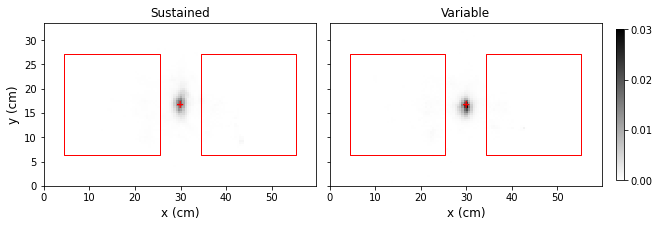

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])

sns.histplot(sustained_gaze, x='x', y='y', cbar=True, stat='probability', cmap='gray_r', bins=(120, 78), ax=ax[0], vmin=0, vmax=0.03, cbar_ax=cax)
ax[0].text(59.8 / 2, 33.6 / 2, '+', ha='center', va='center', fontsize=10, color='red', fontweight='bold')

im_len = 59.8 / 2 - 9
y = (33.6 - im_len) / 2
x1 = 4.5
x2 = (59.8 / 2) + 4.5

images = [Rectangle((x1, y), im_len, im_len, fill=False, color='red', lw=1),
          Rectangle((x2, y), im_len, im_len, fill=False, color='red', lw=1)]
pc = PatchCollection(images, match_original=True)
ax[0].add_collection(pc)

ax[0].set_xlabel('x (cm)', fontsize=12)
ax[0].set_ylabel('y (cm)', fontsize=12)
ax[0].set_title('Sustained', fontsize=12)

sns.histplot(variable_gaze, x='x', y='y', cbar=False, stat='probability', cmap='gray_r', bins=(120, 78), ax=ax[1], vmin=0, vmax=0.03)
ax[1].text(59.8 / 2, 33.6 / 2, '+', ha='center', va='center', fontsize=10, color='red', fontweight='bold')
pc = PatchCollection(images, match_original=True)
ax[1].add_collection(pc)

ax[1].set_xlim(0, 59.8)
ax[1].set_ylim(0, 33.6)
ax[1].set_xlabel('x (cm)', fontsize=12)
ax[1].set_ylabel('y (cm)', fontsize=12)
ax[1].set_title('Variable', fontsize=12)

cax.set_yticks([0, 0.01, 0.02, 0.03])

plt.subplots_adjust(wspace=0.05)
fig.savefig(os.path.join(figdir, 'gaze_distribution.pdf'), bbox_inches='tight')

Identify trials where gaze intersected either image

In [13]:
def intersect_image(xs, ys):
    im_len = 59.8 / 2 - 9
    y = (33.6 - im_len) / 2
    x1 = 4.5
    x2 = (59.8 / 2) + 4.5

    xs = np.array(xs)
    ys = np.array(ys)

    return ((xs > x1) & (xs < x1 + im_len) & (ys > y) & (ys < y + im_len)).any(), ((xs > x2) & (xs < x2 + im_len) & (ys > y) & (ys < y + im_len)).any()

In [14]:
def add_intersection(behavioral, gaze):
    subjs = behavioral['Subject'].unique()
    for subj in tqdm(subjs):
        stimuli = behavioral.query('Subject == @subj and `Trial Type` == "Presentation"')
        for i, stim in stimuli.iterrows():
            start = stim['Stimulus Onset']
            end = stim['Stimulus Offset']
            gz = gaze.query('Subject == @subj and Time >= @start and Time <= @end')
            if gz.shape[0] > 0:
                behavioral.loc[i, 'Left intersection'], behavioral.loc[i, 'Right intersection']  = intersect_image(gz['x'], gz['y'])
                behavioral.loc[i, 'Intersection detected'] = behavioral.loc[i, 'Left intersection'] or behavioral.loc[i, 'Right intersection']
                behavioral.loc[i, 'Attended intersection'] = (behavioral.loc[i, 'Left intersection'] and behavioral.loc[i, 'Cued Location'] == '<') or (behavioral.loc[i, 'Right intersection'] and behavioral.loc[i, 'Cued Location'] == '>')
    
    return behavioral


In [15]:
sustained_behavioral = add_intersection(sustained_behavioral, sustained_gaze)
variable_behavioral = add_intersection(variable_behavioral, variable_gaze)

100%|██████████| 23/23 [00:52<00:00,  2.28s/it]


In [16]:
def summarize_intersections(df, category='Attended intersection'):
    df = df.query('`Trial Type` == "Presentation"').fillna(False)
    return df[['Subject', 'Run', category]].groupby(['Subject', 'Run']).mean().reset_index().rename({category: 'Intersection'}, axis=1)

In [17]:
intersection_type = 'Attended intersection'

def plot_intersections(intersection_type, fname=None):
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey=True)
    # sustained
    df = summarize_intersections(sustained_behavioral, category=intersection_type)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Run', y='Intersection', ax=ax[0, 0], color='gray')
    ax[0, 0].set_title('Sustained', fontsize=12);
    ax[0, 0].set_ylabel('Proportion of trials', fontsize=12);

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Subject', y='Intersection', ax=ax[1, 0], color='gray')
    ax[1, 0].set_ylabel('Proportion of trials', fontsize=12);
    ax[1, 0].set_xlabel('Subject', fontsize=12);
    ax[1, 0].set_xticklabels([i if i % 5 == 0 else '' for i in range(len(df['Subject'].unique()))]);

    # variable
    df = summarize_intersections(variable_behavioral, category=intersection_type)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Run', y='Intersection', ax=ax[0, 1], color='gray')
    ax[0, 1].set_title('Variable', fontsize=12);
    ax[0, 1].set_xlabel('Run', fontsize=12);
    ax[0, 1].set_ylabel('');

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Subject', y='Intersection', ax=ax[1, 1], color='gray')
    ax[1, 1].set_ylabel('');
    ax[1, 1].set_xlabel('Subject', fontsize=12);
    ax[1, 1].set_xticklabels([i if i % 5 == 0 else '' for i in range(len(df['Subject'].unique()))]);

    ax[0, 0].set_ylim(0, 1)
    plt.tight_layout()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

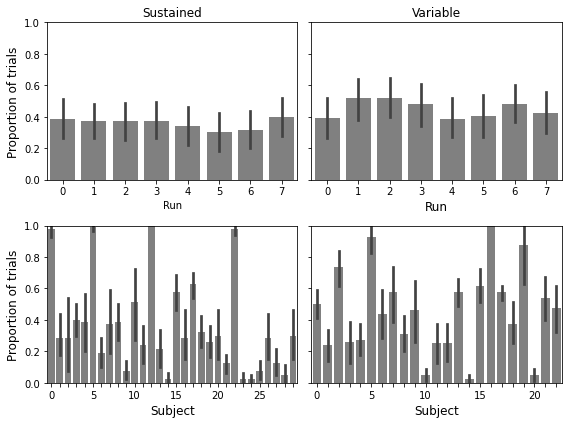

In [18]:
plot_intersections('Attended intersection', 'attended_gaze_intersections');

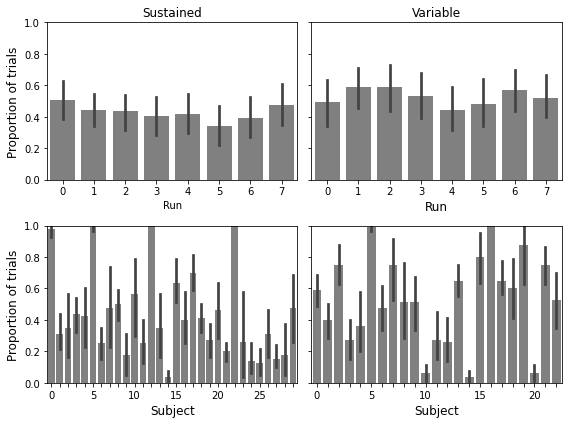

In [19]:
plot_intersections('Intersection detected', 'all_gaze_intersections');

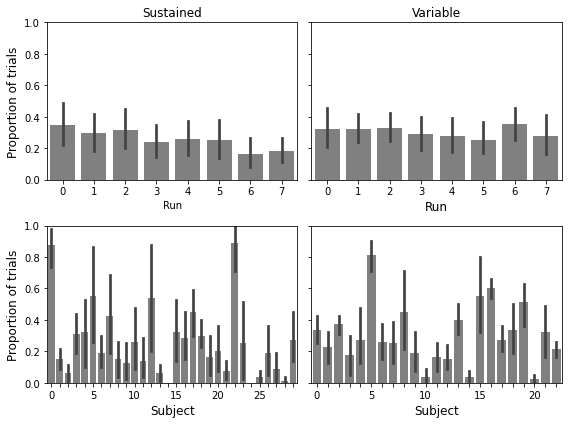

In [20]:
plot_intersections('Left intersection', 'left_gaze_intersections');

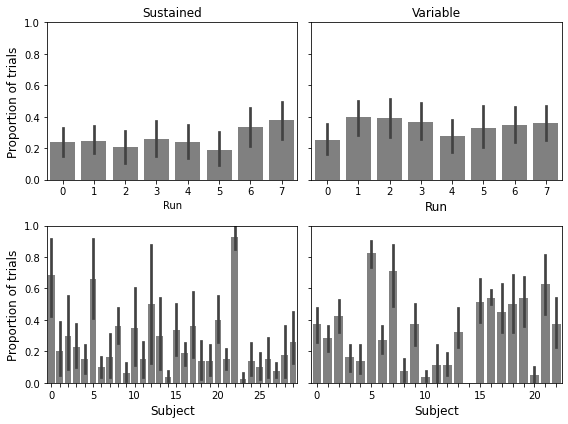

In [21]:
plot_intersections('Right intersection', 'right_gaze_intersections');

Behavioral analyses:
  - For attended and unattended targets:
    - Are attended images rated as more familiar?
    - Are attended categories rated as more familiar?
    - Are attended locations rated as more familiar?
  - For novel images:
    - Are attended categories rated as more familiar?  (Response bias)

Regress out looking time?


labels:
- 'Category': face, scene
- 'Location': left, right
- 'Attention': attended, cued location, cued category, novel

In [27]:
def image_finder(image, stimuli):
    kind = 'Place' if image[:3] == 'sun' else 'Face'
    cues = {k: stimuli[k].apply(lambda x: image in x if type(x) is str else False) for k in ['Cued Face', 'Cued Place', 'Uncued Face', 'Uncued Place']}
    matches = np.sum([v.values for v in cues.values()], axis=0).astype(bool)
    
    if len(matches) > 0 and np.any(matches):
        side = 'Left' if stimuli.loc[matches]['Cued Location'].values[0] == '<' else 'Right'
        category = stimuli.loc[matches]['Cued Category'].values[0]
    else:
        side = None
        category = None
    
    return kind, cues, matches, side, category

In [28]:
def add_behavioral_labels(df):
    subjs = df['Subject'].unique()
    for subj in tqdm(subjs):
        stimuli = df.query('Subject == @subj and `Trial Type` == "Presentation"')
        probes = df.query('Subject == @subj and `Trial Type` == "Memory"')

        for i, probe in probes.iterrows():
            kind, cues, _, side, category = image_finder(probe['Memory Image'], stimuli)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                df.loc[i, 'Category'] = kind
                df.loc[i, 'Cued Location'] = side
                df.loc[i, 'Cued Category'] = category

                if side is None:
                    df.loc[i, 'Attention'] = 'Novel'
                elif np.any(cues['Cued Place']):
                    if category == 'Place':
                        df.loc[i, 'Attention'] = 'Attended'
                    else:
                        df.loc[i, 'Attention'] = 'Attended location'
                elif np.any(cues['Uncued Place']):
                    if category == 'Place':
                        df.loc[i, 'Attention'] = 'Attended category'
                    else:
                        df.loc[i, 'Attention'] = 'Unattended'
                elif np.any(cues['Cued Face']):
                    if category == 'Face':
                        df.loc[i, 'Attention'] = 'Attended'
                    else:
                        df.loc[i, 'Attention'] = 'Attended location'
                elif np.any(cues['Uncued Face']):
                    if category == 'Face':
                        df.loc[i, 'Attention'] = 'Attended category'
                    else:
                        df.loc[i, 'Attention'] = 'Unattended'
                else:
                    df.loc[i, 'Attention'] = 'Novel'

    return df

In [29]:
sustained_behavioral = add_behavioral_labels(sustained_behavioral)
variable_behavioral = add_behavioral_labels(variable_behavioral)

100%|██████████| 23/23 [00:03<00:00,  6.68it/s]


In [30]:
attention_colors = {
    'Attended': '#BE1E2D',
    'Attended category': '#F15A29',
    'Attended location': '#F9ED32',
    'Unattended': '#009444',
    'Novel': '#27AAE1',
    'Face': '#000000',
    'Place': '#000000'
}

In [31]:
def plot_attention(df, fname=None, palette=attention_colors, id_vars=['Subject', 'Attention', 'Run'], val_vars=['Familiarity Rating'], ylim=[1.75, 2.75], **kwargs):
    fig = plt.figure(figsize=(4, 3))
    ax = plt.gca()

    order = ['Attended', 'Attended category', 'Attended location', 'Unattended', 'Novel']

    if 'hue' in kwargs:
        id_vars.append(kwargs['hue'])

    sns.barplot(data=df.query('`Trial Type` == "Memory"')[[*id_vars, *val_vars]].groupby(id_vars).mean().reset_index(), 
                   x='Attention', y='Familiarity Rating', order=['Attended', 'Attended category', 'Attended location', 'Unattended', 'Novel'],  palette=palette, **kwargs);
    ax.set_xlabel('Attention level', fontsize=12);
    ax.set_ylabel('Familiarity rating', fontsize=12);
    ax.set_xticklabels(['' for _ in range(len(ax.get_xticklabels()))]);
    ax.set_ylim(ylim)

    if 'hue' in kwargs:                
        n = len(df[kwargs['hue']].unique()) - 1  # not sure why this correction is needed...
        alphas = np.linspace(1, 0, n + 1)[:-1]

        for i in range(n):
            for j, bar in enumerate(ax.containers[i]):
                bar.set_color(palette[order[j]])
                bar.set_alpha(alphas[i])

    sns.despine(top=True, right=True)

    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig


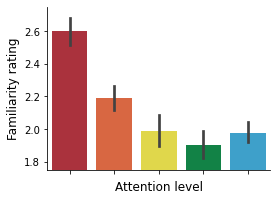

In [32]:
plot_attention(sustained_behavioral, fname='sustained_attention');

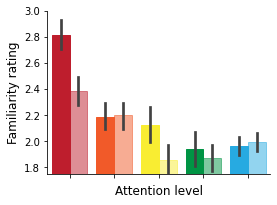

In [33]:
plot_attention(sustained_behavioral, hue='Category', ylim=[1.75, 3], fname='sustained_attention_by_category');

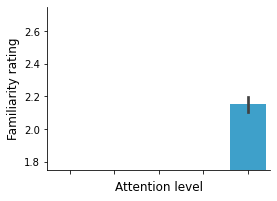

In [34]:
plot_attention(variable_behavioral, fname='variable_attention');

ValueError: Grouper for 'Category' not 1-dimensional

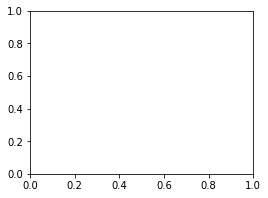

In [35]:
plot_attention(variable_behavioral, fname='variable_attention_by_category', hue='Category', ylim=[1.75, 3]);